In [230]:
import pandas as pd
import numpy as np
import os


base_dir = r"Hyeto-Hydrograph and Rating Curve Analysis Output\Cagayan"
all_xlsx = []

for path, subdirs, files in os.walk(base_dir):
    for filename in files:
        if filename.split('.')[-1] == 'xlsx':
            f = os.path.join(path, filename)
            all_xlsx.append(str(f))
all_xlsx

['Hyeto-Hydrograph and Rating Curve Analysis Output\\Cagayan\\Cagayan July to September 2021\\Cagayan July to September 2021 Summative Excel.xlsx',
 'Hyeto-Hydrograph and Rating Curve Analysis Output\\Cagayan\\Cagayan October to December 2021\\Cagayan October to December 2021 Summative Excel.xlsx',
 'Hyeto-Hydrograph and Rating Curve Analysis Output\\Cagayan\\Cagayan January to March 2022\\Cagayan January to March 2022 Summative Excel.xlsx',
 'Hyeto-Hydrograph and Rating Curve Analysis Output\\Cagayan\\Cagayan April to June 2022\\Cagayan April to June 2022 Summative Excel.xlsx']

In [231]:
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import scipy.stats as sp
import random as rnd

OUTPUT_PATH = r"Inflow Duration Curve\Log Curve"


def flow_druration_curve(df, add_title=None):
    #Get dates for save file name
    start = pd.to_datetime(df['Timestamp'][0]).month_name()
    start_year = pd.to_datetime(df['Timestamp'][0]).year
    last = pd.to_datetime(df['Timestamp'][df.shape[0]-5]).month_name()
    last_year = pd.to_datetime(df['Timestamp'][df.shape[0]-5]).year
    
    df = df[['Flow']].sort_values(by='Flow', ascending=True)

    global prob, data
    data = df['Flow']

    ranks = sp.rankdata(df['Flow'].to_numpy(),'average')
    flow_duration = 100*(ranks/(ranks.shape[0]+1))

    #Gets the probability of exceedance and the flow
    prob = flow_duration[::-1]
    data = data.to_numpy()
    
    #add significant x val
    sig_nos = [50,60,70,80,90,95]
    xvals = 100-np.array(sig_nos)
    yinterp = np.interp(xvals, np.sort(prob), np.sort(data))
    xvals = 100-xvals
    
    #Plot
    fig, ax = plt.subplots(figsize=[15,10])

    ax.plot(prob, data)
    #FDC Elements
    if add_title != None:
        title=f"{add_title} Flow Duration Curve of Cagayan River from {start} {start_year} - {last} {last_year}"
    else:
        title=f"Flow Duration Curve of Cagayan River from {start} {start_year} - {last} {last_year}"
    ylabel=r'Flow ($\frac{m^3}{day}$)'
    xlabel='Percentage of Exceedance (%)'
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_yscale('log') #Uncomment for Log
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True, 'both')

    #Table for significant valies
    col_lables = [f"{i}%" for i in sig_nos]
    row_labels = [ylabel]
    cell_text = [[f"{round(i,2)}" for i in yinterp]]

    ax.table(cell_text, loc='bottom', rowLabels=row_labels, colLabels=col_lables,cellLoc='center', bbox=[0.1, -0.2, 0.8, 0.1])
    
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()

    # plt.tight_layout()
    #Save fig
    if add_title != None:
        filename = f"{add_title} {start} {start_year} - {last} {last_year}.png"
    else:
        filename = f"{start} {start_year} - {last} {last_year}.png"
    
    fig.savefig(os.path.join(OUTPUT_PATH,filename))

    dct = {"title":title,
           "ylabel":ylabel,
           "xlabel":xlabel,
           "col_labels":col_lables,
           "row_labels":row_labels,
           "cell_text":cell_text}
    return prob, data, dct

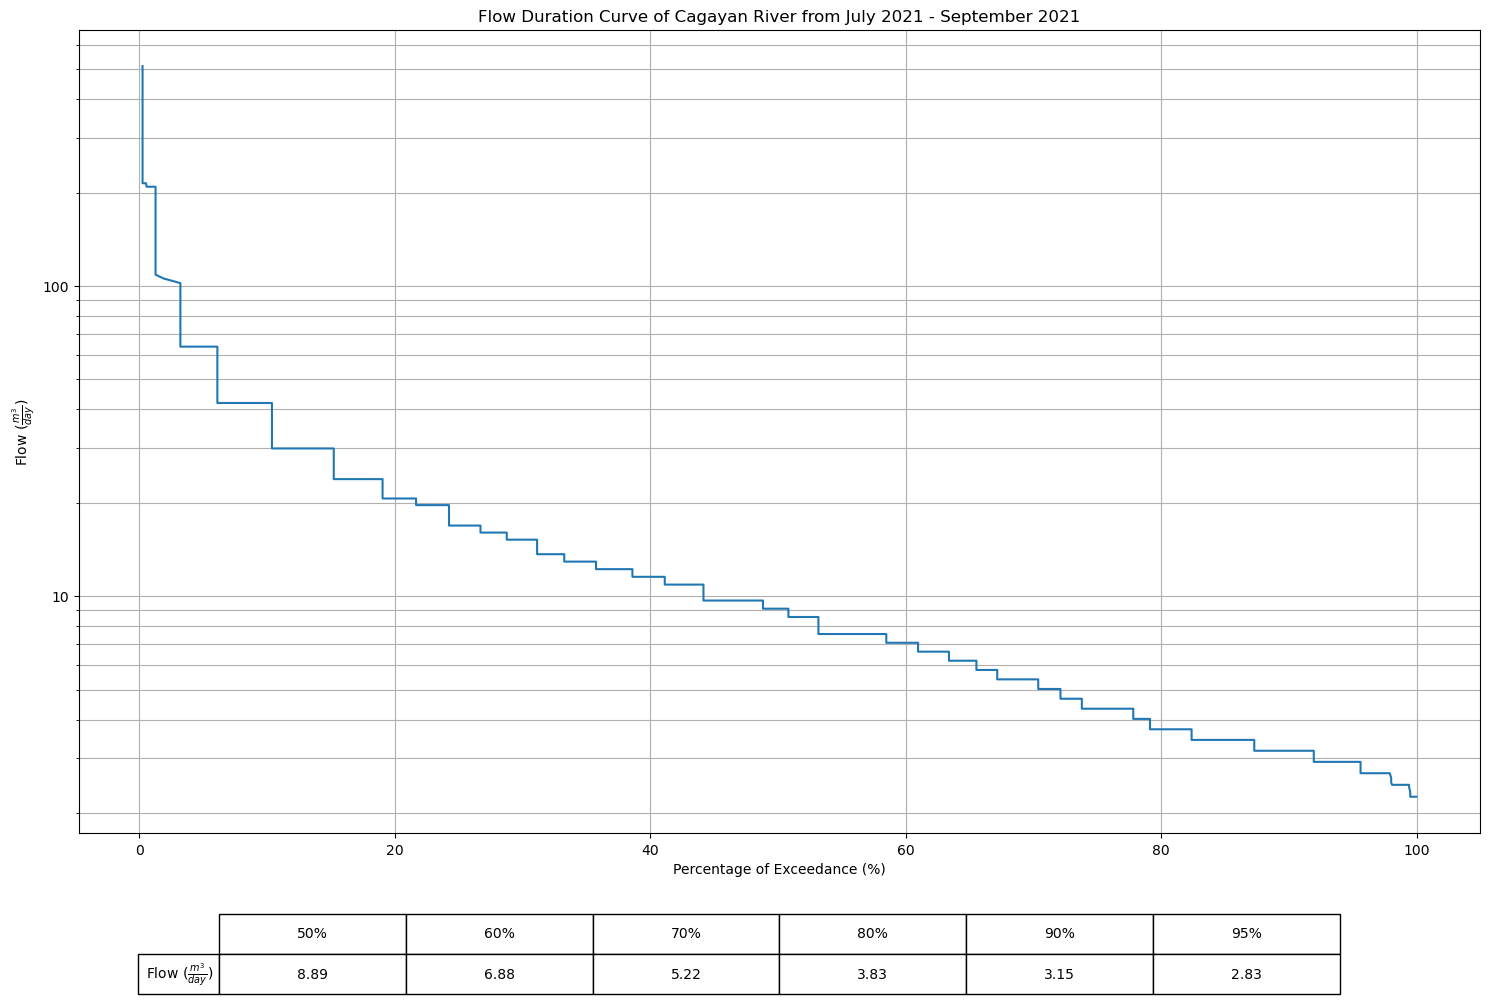

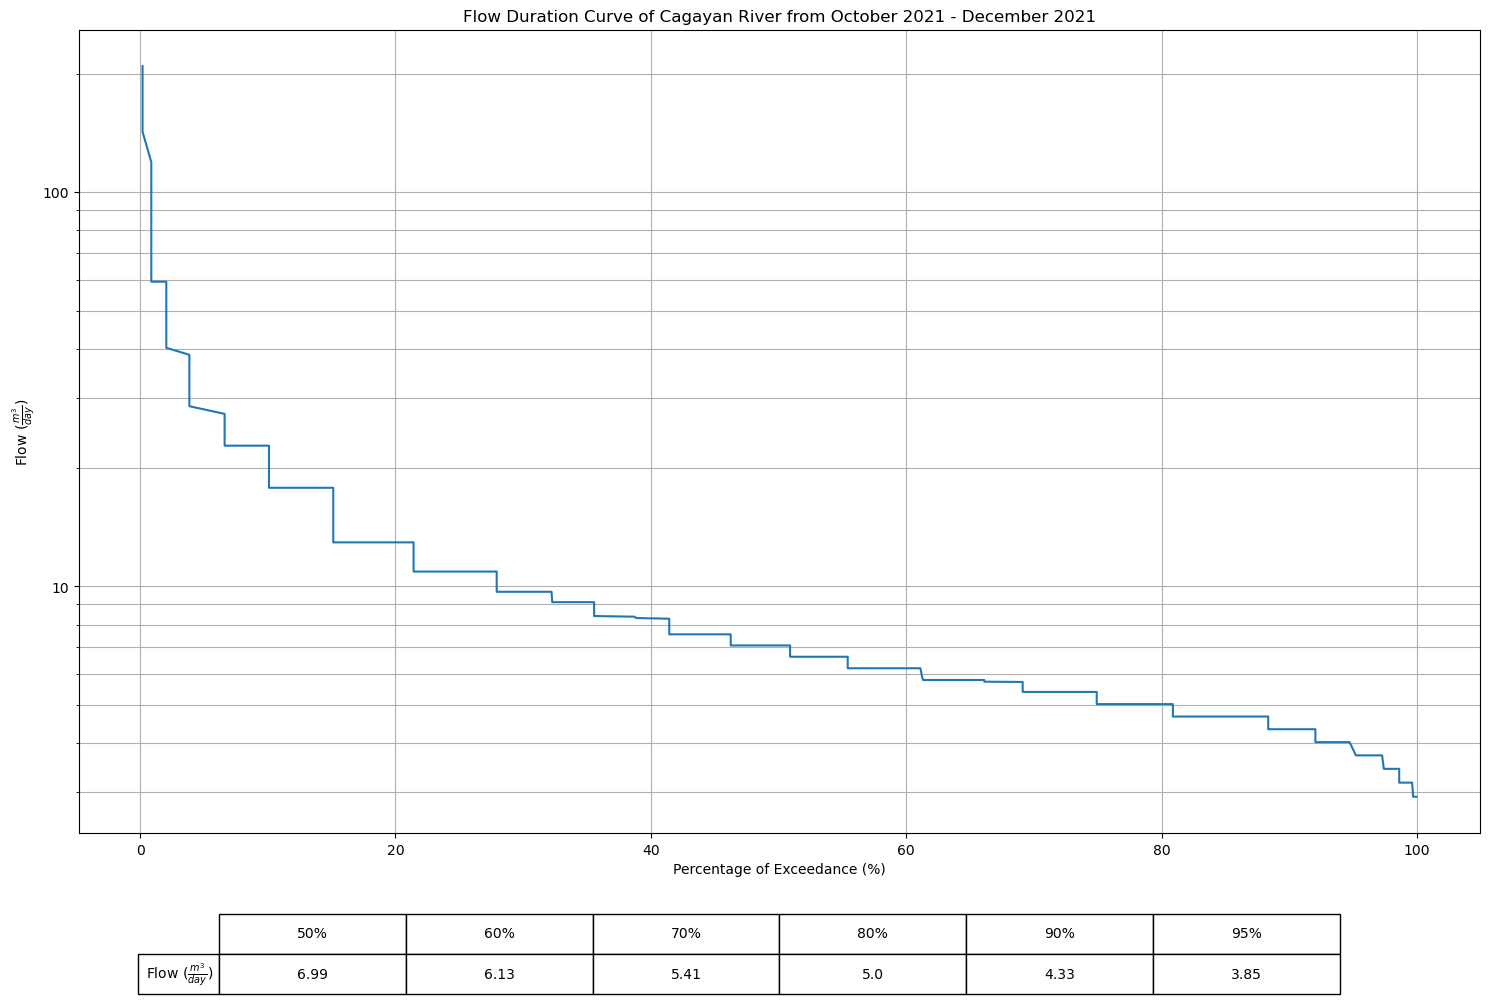

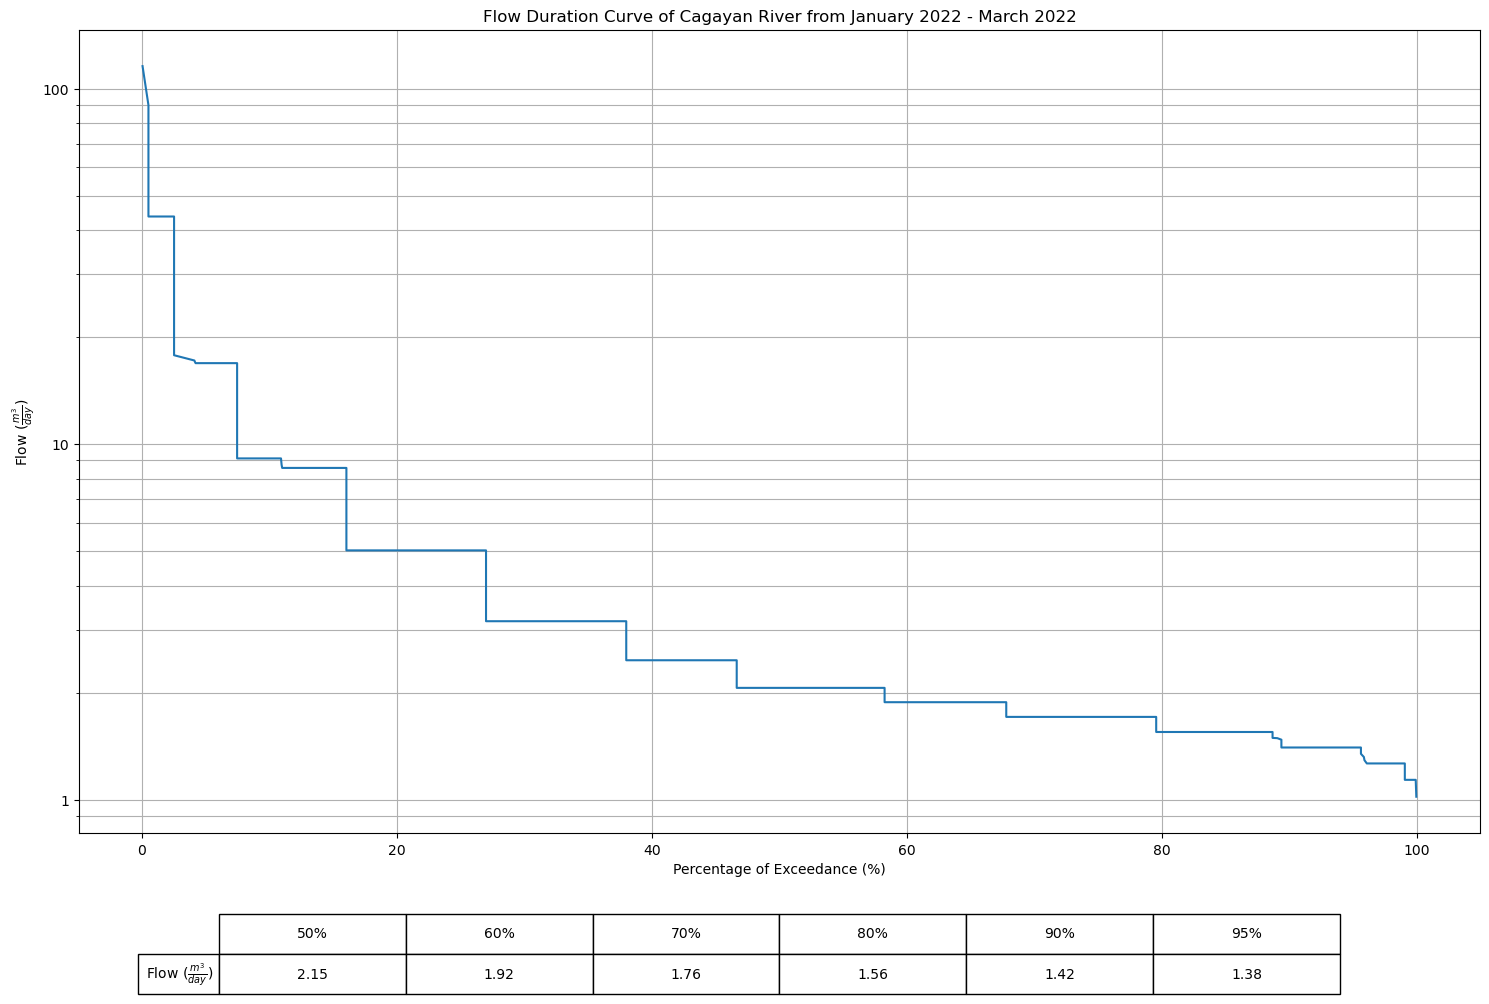

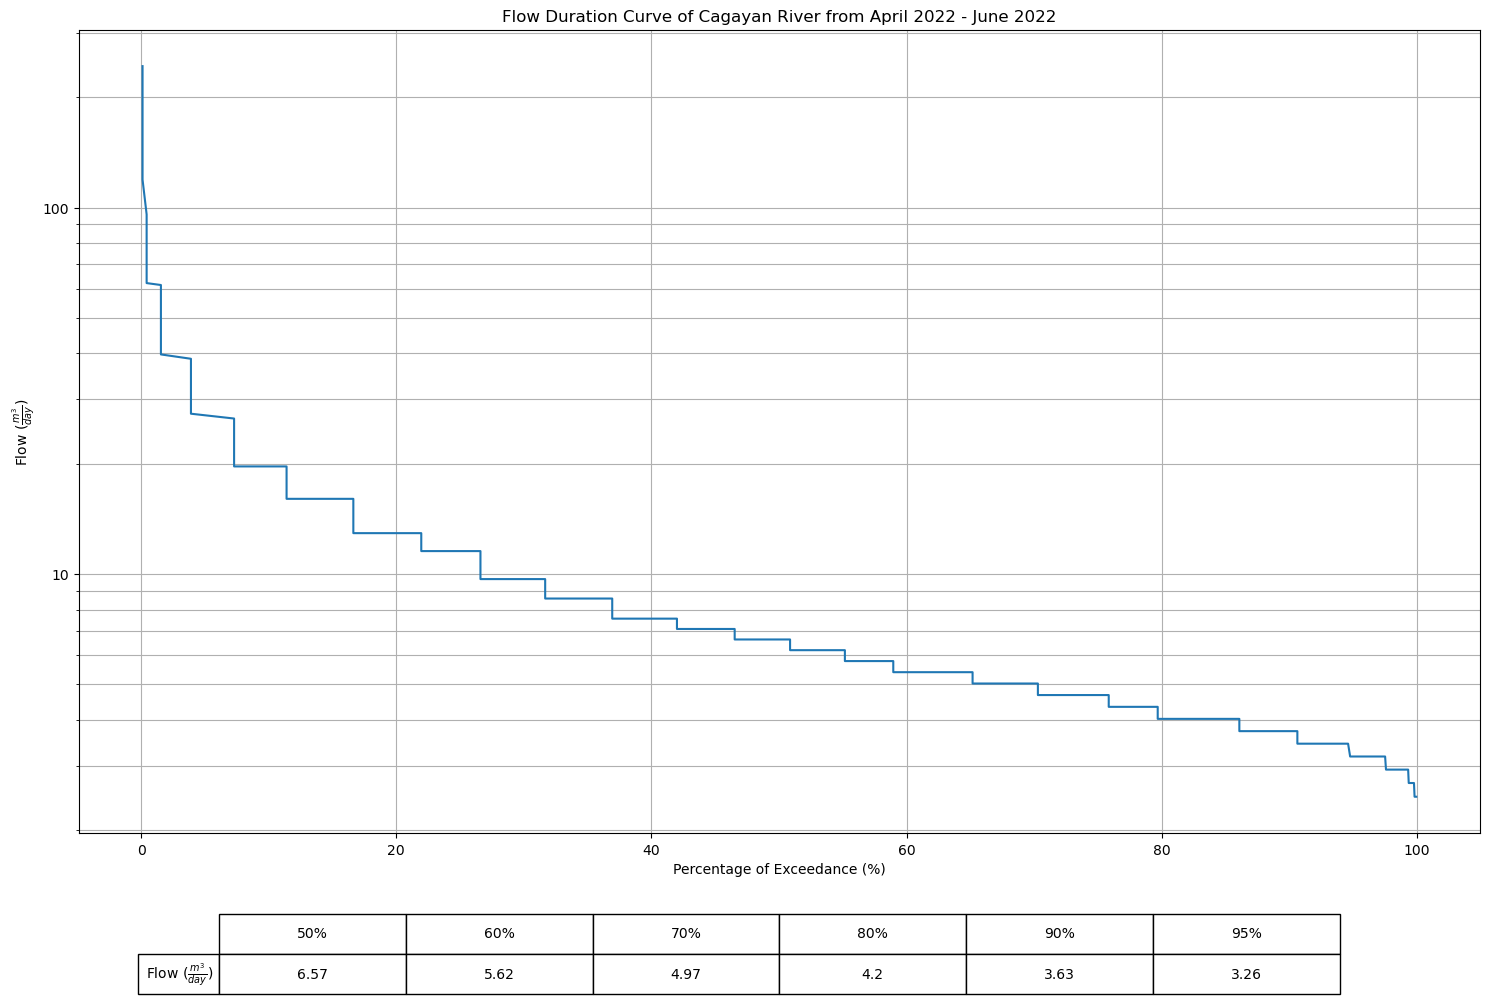

In [232]:
all_df = []
for file in all_xlsx:

    df = pd.read_excel(file, sheet_name='Raw', index_col=0)
    df = df[['Timestamp','Flow']]

    all_df.append(df)

    flow_druration_curve(df)

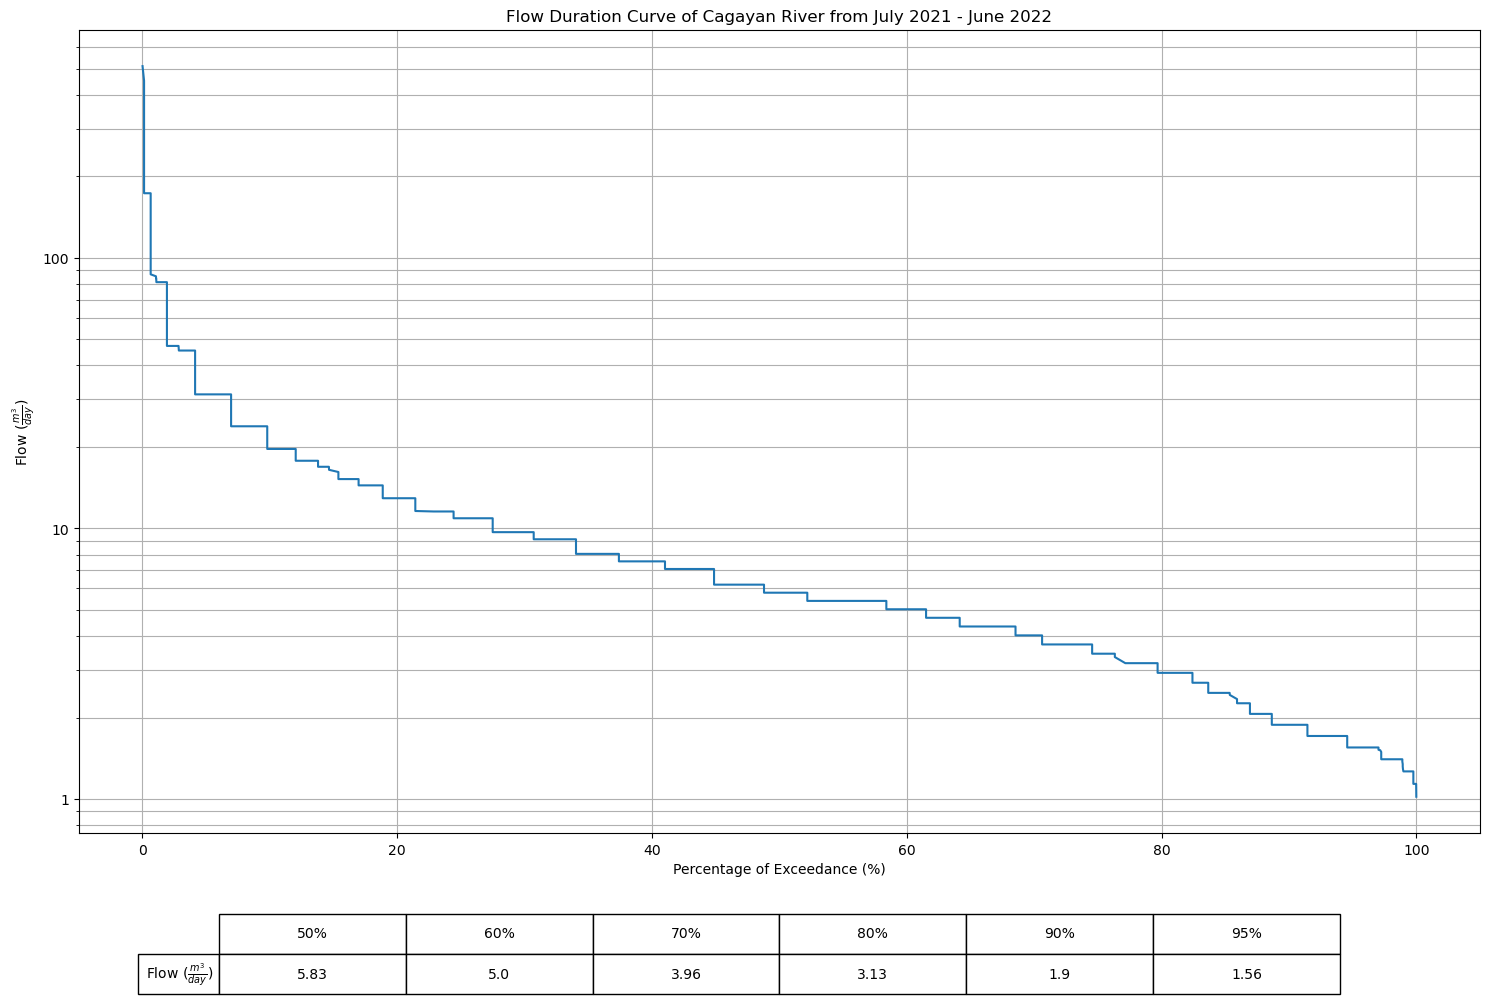

In [233]:
df = pd.concat(all_df, ignore_index=True)
fg_prob, fg_data, fg_dct = flow_druration_curve(df)
df.to_excel("Inflow Duration Curve\Flow Duration Curve Raw Data.xlsx")

### Historical Cagayan Flow Comparison

In [234]:
import pandas as pd
import numpy as np
from tqdm import tqdm
BASE_PATH = "Historical Flow\Cagayan River\Historical Flow.xlsx"

#Get sheet names
years = pd.ExcelFile(BASE_PATH).sheet_names

#Extract all the data
all_df = []
for year in tqdm(years):
    df = pd.read_excel(BASE_PATH, index_col=0, sheet_name=year)
    #Get flow data in order
    dates = []
    data = []

    for col in range(df.shape[1]):
        for row in range(df.shape[0]):
            datum = df.iloc[row, col]
            if np.isnan(datum): #Skip if nan
                continue
            name = f"{year}-{col+1}-{row+1}" #Year-Month-Date
            dates.append(name)
            data.append(datum)

    df = pd.DataFrame({"Timestamp":dates, "Flow":data})
    all_df.append(df)

df = pd.concat(all_df).reset_index(drop=True)
#convert the flow from cubic meters -> cms
df['Flow'] = df['Flow'].to_numpy()/1000
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y-%m-%d")
main_df = df
df

100%|██████████| 26/26 [00:02<00:00,  9.18it/s]


,Timestamp,Flow
0,1991-1-16,44.30
1,1991-1-17,40.00
2,1991-1-18,40.00
3,1991-1-19,40.00
4,1991-1-20,40.00
...,...,...
9230,2019-12-27,50.71
9231,2019-12-28,47.77
9232,2019-12-29,45.11
9233,2019-12-30,45.11


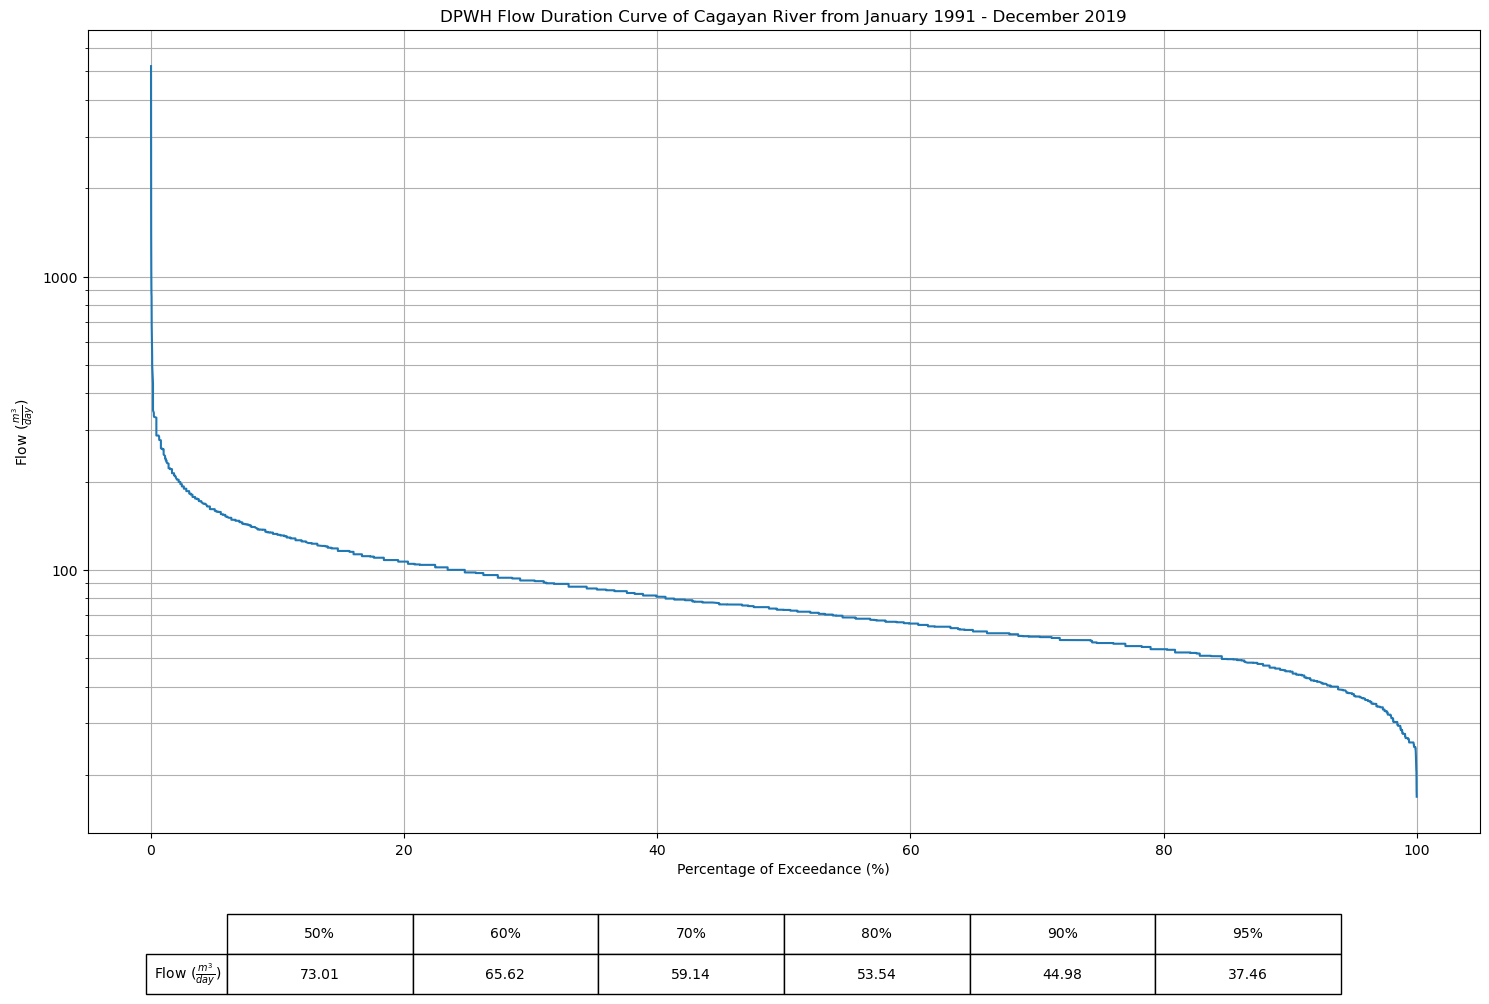

In [235]:
cdo_prob, cdo_data, cdo_dct = flow_druration_curve(main_df, add_title="DPWH")

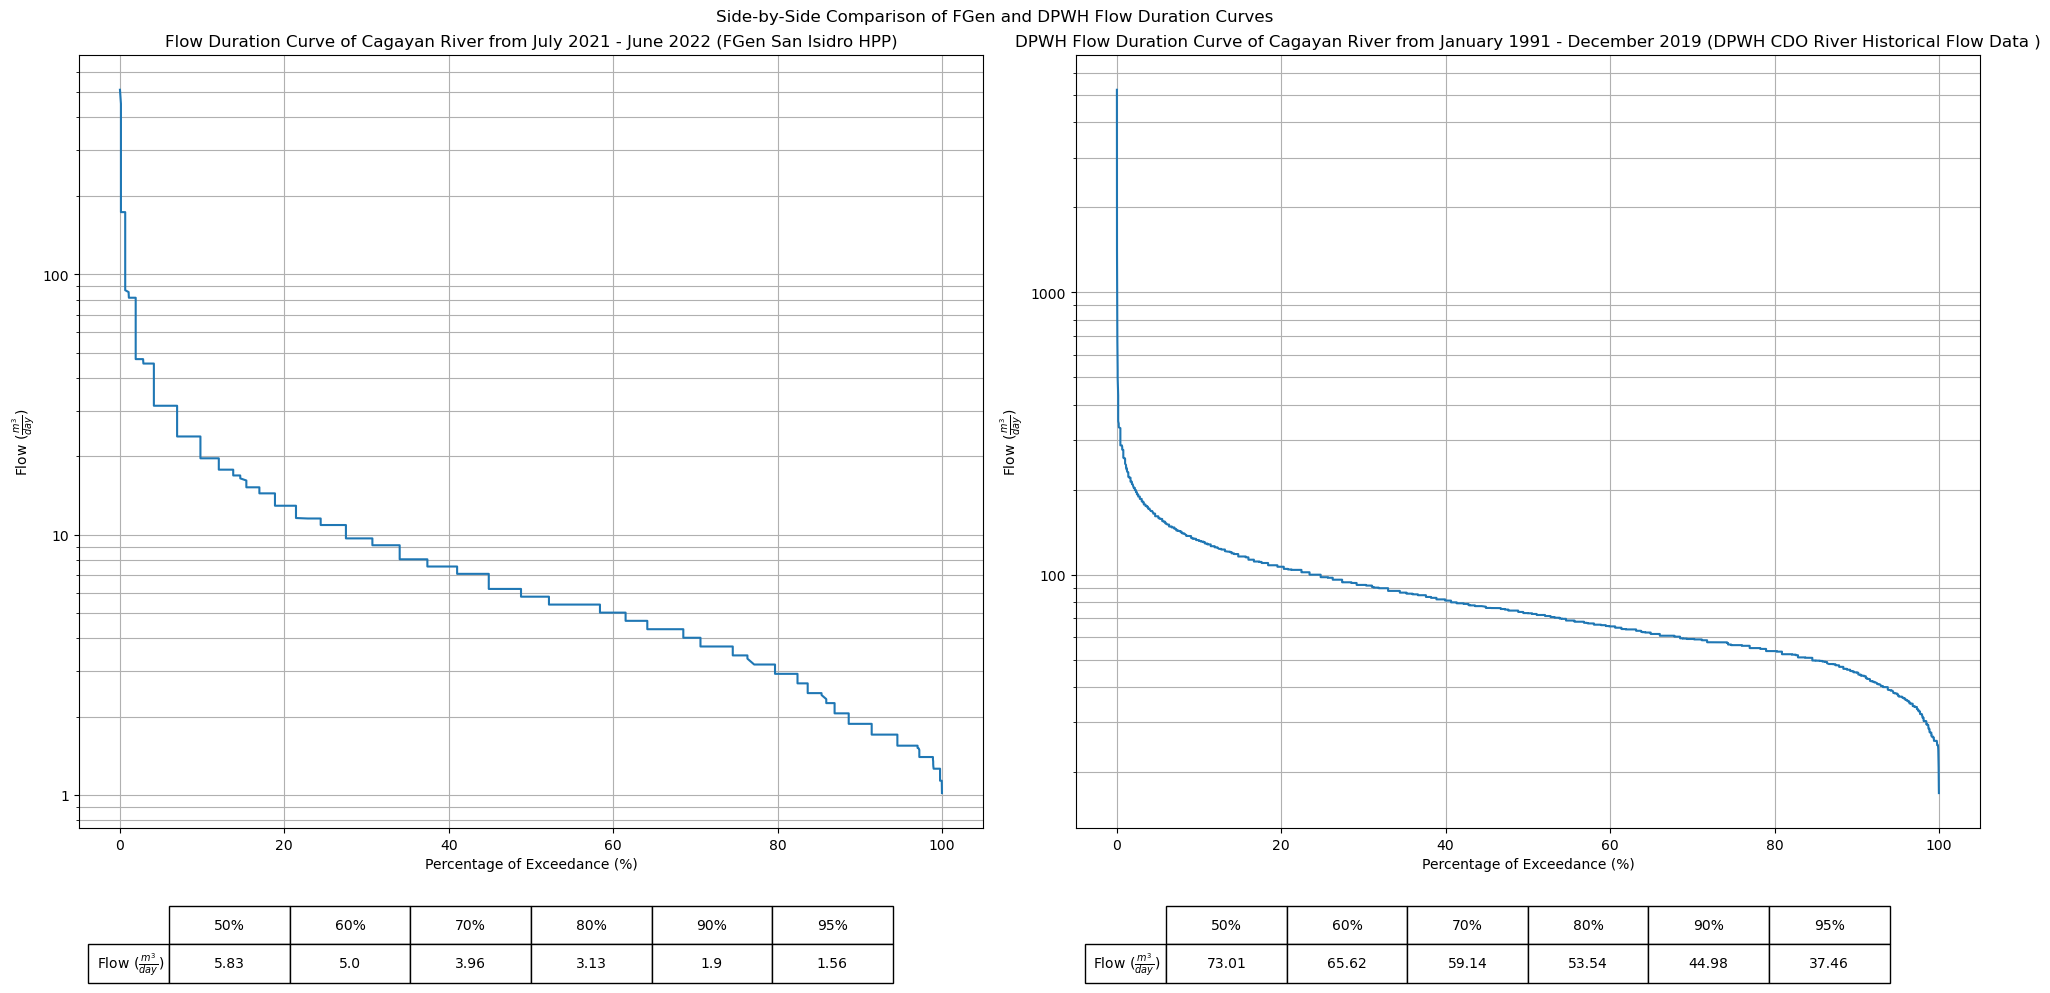

In [236]:
final_fig, final_ax = plt.subplots(1,2, figsize=[20,10])
all_data = [[fg_prob, fg_data, fg_dct], [cdo_prob, cdo_data, cdo_dct]]
titles = ['(FGen San Isidro HPP)', '(DPWH CDO River Historical Flow Data )']


for idx, vals in enumerate(all_data):
    prob = vals[0]
    data = vals[1]
    dct = vals[2]
    ax = final_ax[idx]
    
    ax.plot(prob, data)
    #FDC Elements
    title=dct['title']
    ylabel=dct['ylabel']
    xlabel=dct['xlabel']
    ax.set_title(f'{title} {titles[idx]}')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_yscale('log') #Uncomment for Log
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True, 'both')

    #Table for significant valies
    col_lables = dct['col_labels']
    row_labels = dct['row_labels']
    cell_text = dct['cell_text']

    ax.table(cell_text, loc='bottom', rowLabels=row_labels, colLabels=col_lables,cellLoc='center', bbox=[0.1, -0.2, 0.8, 0.1])
final_title = "Side-by-Side Comparison of FGen and DPWH Flow Duration Curves"
final_fig.suptitle(final_title)
    
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
final_fig.savefig(os.path.join(OUTPUT_PATH,f'{final_title}.png'))

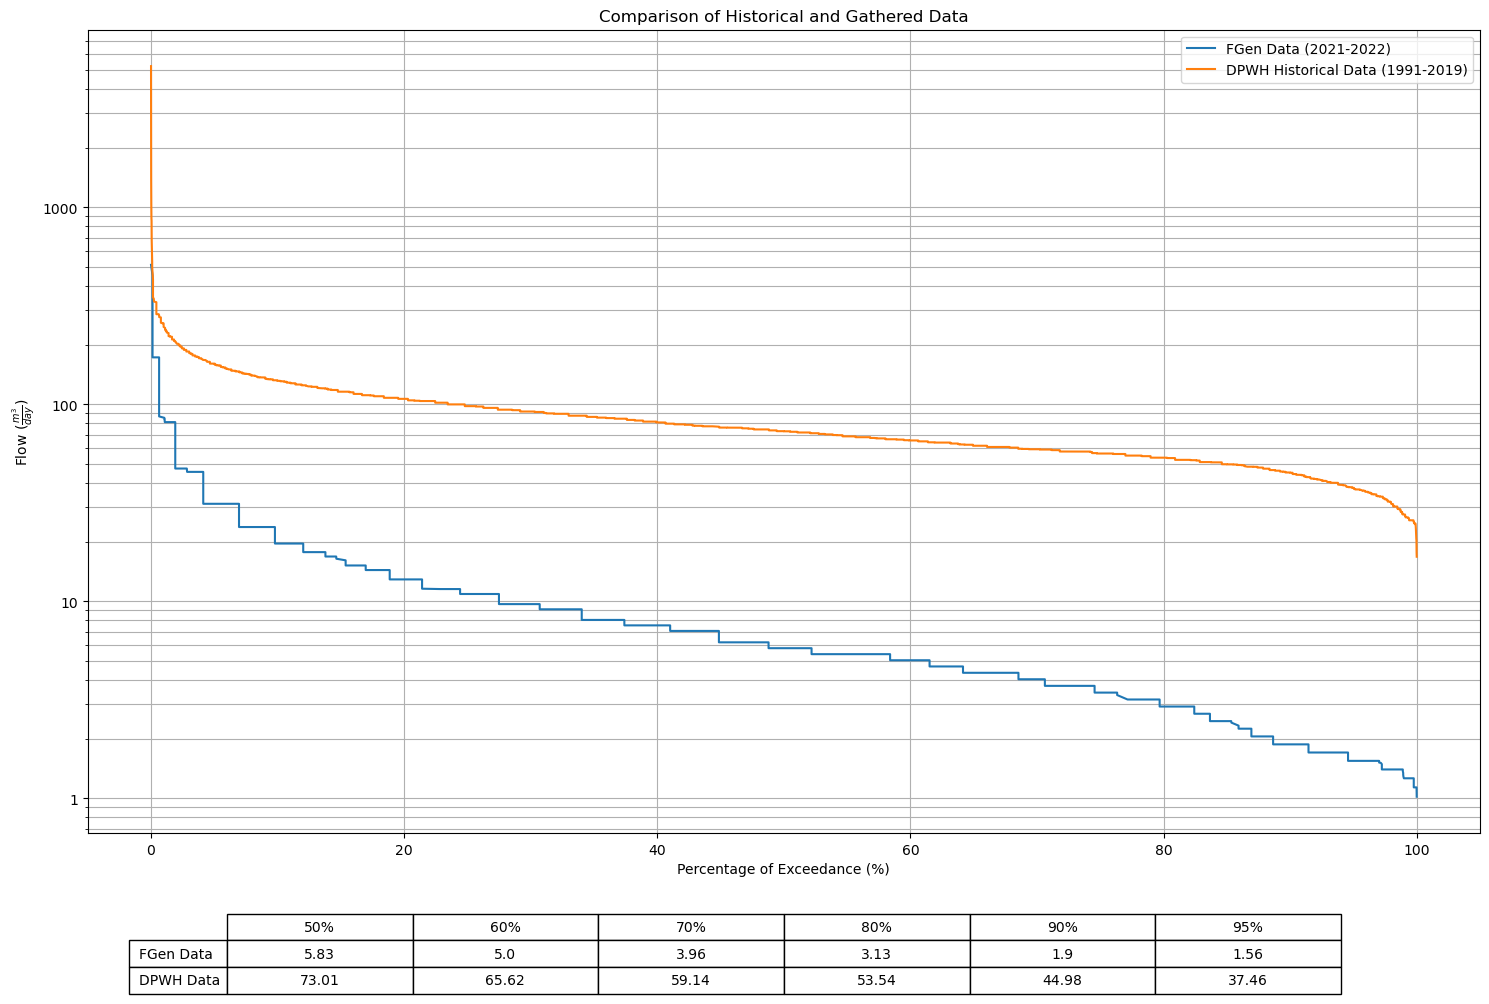

In [237]:
final_fig, final_ax = plt.subplots(figsize=[15,10])
all_data = [[fg_prob, fg_data, fg_dct], [cdo_prob, cdo_data, cdo_dct]]

for idx, vals in enumerate(all_data):
    prob = vals[0]
    data = vals[1]
    dct = vals[2]
    ax = final_ax

    if idx==0:
        legend = "FGen Data (2021-2022)"
    else:
        legend = "DPWH Historical Data (1991-2019)"
    ax.plot(prob, data, label=legend)
    #FDC Elements
    title="Comparison of Historical and Gathered Data"
    ylabel=dct['ylabel']
    xlabel=dct['xlabel']
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_yscale('log') #Uncomment for Log
    ax.yaxis.set_major_formatter(ScalarFormatter())


col_lables = fg_dct['col_labels']
row_labels = ['FGen Data', 'DPWH Data']
cell_text = []
for row in [fg_dct['cell_text'], cdo_dct['cell_text']]:
    for data in row:
        cell_text.append(data)



ax.table(cell_text, loc='bottom', rowLabels=row_labels, colLabels=col_lables,cellLoc='center', bbox=[0.1, -0.2, 0.8, 0.1])

ax.grid(True, 'both')
ax.legend()
    
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
final_fig.savefig(os.path.join(OUTPUT_PATH, f"{title}.png"))